# Genshin Impact Google Play Sentiment Reviews

# Imports

In [156]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

# Models 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.gaussian_process import GaussianProcessClassifier
from xgboost import XGBClassifier

# Data Processing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import make_scorer, f1_score
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score, GridSearchCV
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, ADASYN

from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModel


from collections import Counter

import torch
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from nltk.tokenize import word_tokenize
from scipy.special import softmax

import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# Functions

In [166]:
def check_class_imbalance(df:pd.DataFrame, target:pd.Series, col:str):
  counter = Counter(target)
  for k,v in counter.items():
    per = v/len(target) * 100
    print("Class=%s, Count=%d, Percentage=%.3f%%" % (k,v, per))
  
  ax = df[col].value_counts().sort_index().plot(
  kind="bar", 
  title="Count of Reviews by Target", 
  figsize=(10,5)
  )
  ax.set_xlabel(col)
  plt.show()
  
def remove_stop_words(review:str):
    word_tokens = " ".join(word_tokenize(review))
    filtered_word_tokens = re.sub(r'[^a-zA-Z\s]', '', word_tokens).split(" ")
    filtered_sentence = [w.lower().strip() for w in filtered_word_tokens if not w.lower() in ENGLISH_STOP_WORDS]
    return ' '.join(filtered_sentence).strip()
def evaluate_model(X, y, model):
  cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
  
  metric = make_scorer(f1_score)
  scores = cross_val_score(model, X, y, scoring=metric, cv=cv, n_jobs=-1)
  return scores

def testing_selected_models(names:list, models:list, X:pd.DataFrame, y:pd.Series):
    """
    Runs multiple subsets on folds of data

    Args:
        names (list): _description_
        models (list): _description_
    """
    model_performance = []
    for i in range(len(models)):
        model = models[i]
        # Evaluate the model
        scores = evaluate_model(X, y, model)
        # summarize and store
        model_performance.append({
            "Model": names[i],
            "Mean": np.mean(scores),
            "STD":np.std(scores)
        })
    performance_df = pd.DataFrame(model_performance)
    return performance_df.sort_values(by="Mean", ascending=False)
def get_selected_models(names):
  """
  Returns selected models for ML processing

  Args:
      names (_type_):List

  Returns:
      List of models
  """
  models = {
    "LDA": LinearDiscriminantAnalysis(),
    "GPC": GaussianProcessClassifier(),
    "GNB": GaussianNB(),
    "SVC": SVC(),
    "LR":LogisticRegression(max_iter=1000),
    "KNN": KNeighborsClassifier(),
    "DTC": DecisionTreeClassifier(),
    "GBC":GradientBoostingClassifier(),
    "RFC":RandomForestClassifier(),
    "XGB": XGBClassifier(),
    "MN": MultinomialNB()
  }
  
  return [models[model] for model in names]

def get_over_sampling_methods(X, y, name):
  
  sampling_models = {
    "KNN-SMOTE":SMOTE(k_neighbors=5, random_state=42),
    "BL-SMOTE": BorderlineSMOTE(kind='borderline-1', random_state=42),
    "SMOTE": SMOTE(),
    "ADASYN": ADASYN(random_state=42)
  }
  
  smapling_model = sampling_models[name]
  X_res, y_res = smapling_model.fit_resample(X, y)
  
  return (X_res, y_res)

def test_train_test_val_splits_on_models(names, models, X, y):
    model_performance = []
    
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42)
    
    for i in range(len(models)):
        model, model_name = models[i], names[i]
        model.fit(X_train, y_train)
        
        y_val_pred = model.predict(X_val)
        val_accuracy = accuracy_score(y_val, y_val_pred)
        
        y_test_pred = model.predict(X_test)
        test_accuracy = accuracy_score(y_test, y_test_pred)
        
        cf = classification_report(y_test, y_test_pred)
        print(cf)
        
        model_performance.append({
            "Model": model_name,
            "Validation Accuracy": val_accuracy,
            "Test Accuracy": test_accuracy
        })
        
        conf_mat = confusion_matrix(y_test,y_test_pred)
        plt.figure(figsize=(8,6))
        sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.title(f'Confusion Matrix {model_name}')
        plt.show()
        
    performance_df = pd.DataFrame(model_performance)
    return performance_df.sort_values(by="Validation Accuracy", ascending=False)

def logistic_regression_tune_cv(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
    

    pipeline = LogisticRegression(class_weight='balanced', penalty='l2', max_iter=2000)

    param_grid = {
        'solver': ['newton-cg', 'sag', 'saga', 'lbfgs'],
        'C': [0.1, 0.2, 0.4, 0.5, 1, 2, 4, 5, 10, 20, 50, 100, 400]
    }
    metric = make_scorer(f1_score)
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring=metric, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    print("Best parameters:", grid_search.best_params_)
    print("Best cross-validation score: {:.3f}".format(grid_search.best_score_))
    
    y_test_pred = grid_search.predict(X_test)
    accuracy = accuracy_score(y_test, y_test_pred)
    print(f'Test accuracy: {accuracy:.3f}')
    cr = classification_report(y_test, y_test_pred)
    print(cr)
    conf_mat = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix for LR')
    plt.show()

def val_grid_search_selected_models(param_grid:dict,names:list, models:list, X:pd.DataFrame, y:pd.Series, metric):
    """
    Runs multiple subsets on folds of data

    Args:
        names (list): _description_
        models (list): _description_
    """
    
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

    model_performance = []

    for i in range(len(models)):
        model, name = models[i], names[i]
        pipeline = model
        grid_search = GridSearchCV(pipeline, param_grid[name], cv=5, scoring=metric, n_jobs=-1)
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_
            
        y_pred = best_model.predict(X_val)
        y_test_pred = best_model.predict(X_test)
        
        val_accuracy = accuracy_score(y_val, y_pred)
        test_accuracy = accuracy_score(y_test, y_test_pred)    
        print(f'Best score for {name}: {grid_search.best_score_:.3f}')
        print("Best parameters:", grid_search.best_params_)
        
        print(f'Validation Test accuracy for {name}: {val_accuracy:.3f}')
        print(f'Test accuracy for {name}: {test_accuracy:.3f}')
        print("---------------------------------------------------------------")
        
        conf_mat = confusion_matrix(y_test, y_test_pred)
        cr = classification_report(y_test, y_test_pred)
        print(cr)
        plt.figure(figsize=(8,6))
        sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.title(f'Confusion Matrix for {names[i]}')
        plt.show()
            
        model_performance.append({
                "Model": name,
                "Best CV Score": grid_search.best_score_,
                "Validation Accuracy": val_accuracy,
                "Test Accuracy": test_accuracy,
                "Best Parameters": grid_search.best_params_
        })
    return pd.DataFrame(model_performance).sort_values(by="Test Accuracy", ascending=False)

# EDA Analysis

In [86]:
df = pd.read_csv("/Users/maukanmir/Downloads/genshin_review.csv")
df

,review,rating
0,Absolute Masterpiece i hate the people who gav...,5
1,amazing but the fandom isn't amazing,5
2,Very nice,5
3,Give me gambling money (primo gems),4
4,"This is one my first Open World RPG games, and...",4
...,...,...
990,Yeah,4
991,Getting bored,3
992,This game sucks,1
993,"""If Adventuring in Teyvat was a dream, Genshin...",5


# Check for Nulls and Dupes

In [87]:
print(f"Null Count: {df.isna().sum()}")
print(f"Dupe Count: {df.duplicated().sum()}")

Null Count: review    0
rating    0
dtype: int64
Dupe Count: 47


In [88]:
df.drop_duplicates(inplace=True)

# Check For Class Imbalance

Class=5, Count=514, Percentage=54.219%
Class=4, Count=100, Percentage=10.549%
Class=1, Count=230, Percentage=24.262%
Class=2, Count=46, Percentage=4.852%
Class=3, Count=58, Percentage=6.118%


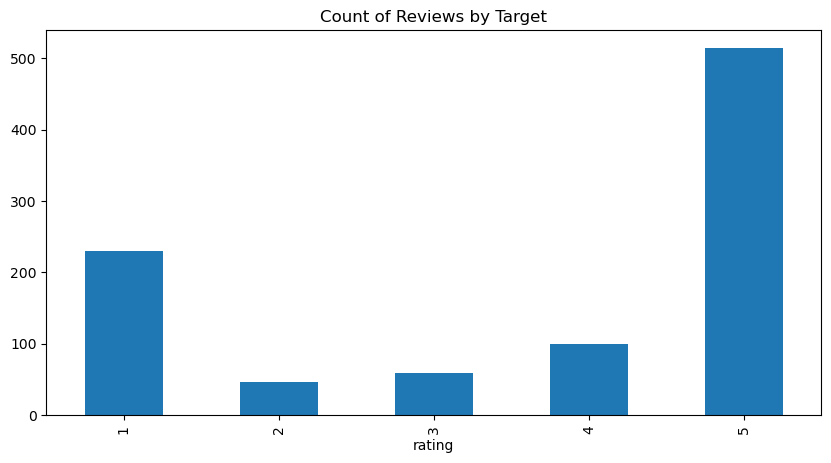

In [89]:
check_class_imbalance(df, df["rating"], "rating")

In [90]:
df['len_text'] = df['review'].apply(lambda x: len(x))
df['num_words'] = df['review'].apply(lambda x: len(x.split())) 

# Visuals

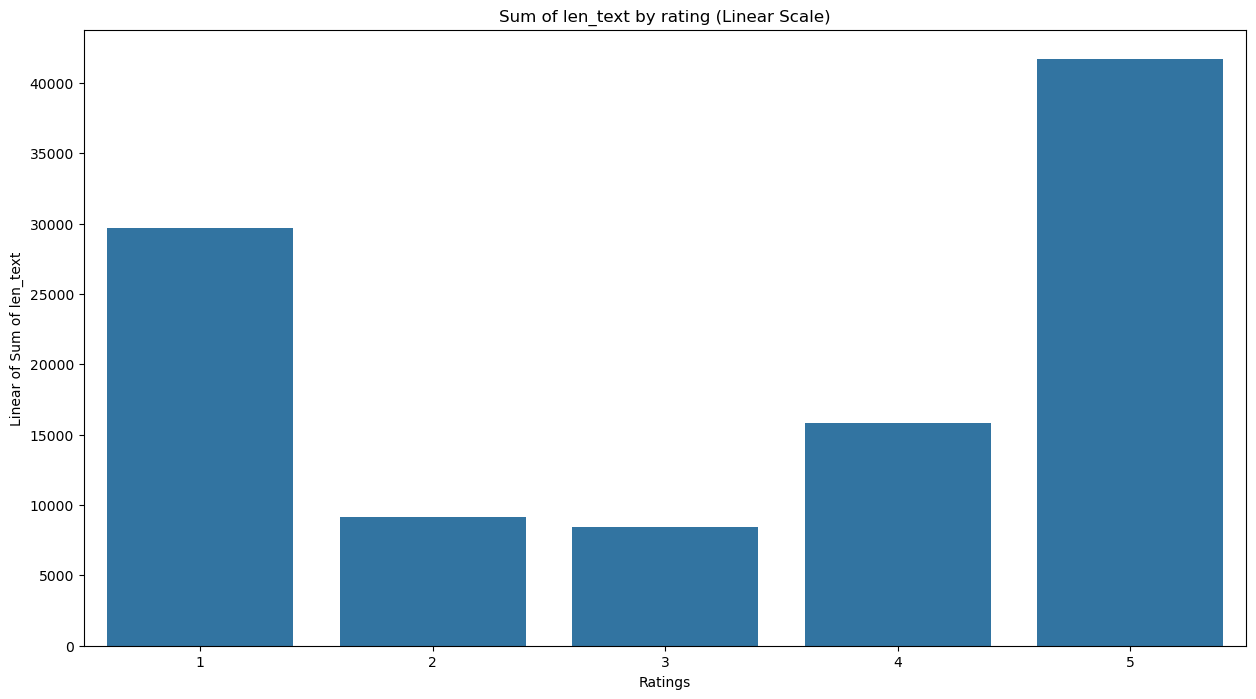

In [9]:
len_text_summary = df.groupby('rating')['len_text'].sum().reset_index()

plt.figure(figsize=(15, 8))
sns.barplot(data=len_text_summary, x='rating', y='len_text')
plt.yscale('linear')
plt.title('Sum of len_text by rating (Linear Scale)')
plt.xlabel('Ratings')
plt.ylabel('Linear of Sum of len_text')
plt.show()

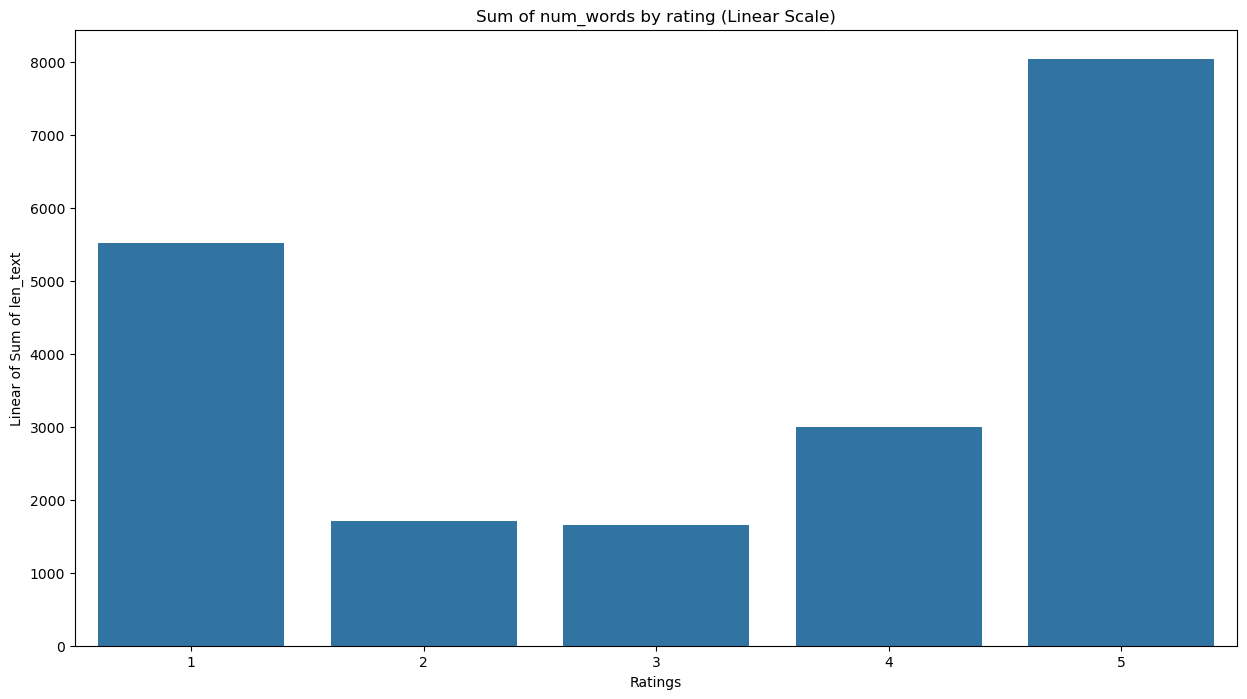

In [11]:
num_words_summary = df.groupby('rating')['num_words'].sum().reset_index()

plt.figure(figsize=(15, 8))
sns.barplot(data=num_words_summary, x='rating', y='num_words')
plt.yscale('linear')
plt.title('Sum of num_words by rating (Linear Scale)')
plt.xlabel('Ratings')
plt.ylabel('Linear of Sum of len_text')
plt.show()

# It seems as if more positive reviews are longer in terms of length of text and words. With Negative review coming in 2nd. Interesting to see that 2 and 3 do seem neutral in regards to the more negative/positive reviews

# BERT Model

In [91]:
MODEL = f'cardiffnlp/twitter-roberta-base-sentiment'
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [99]:
def polarity_scores_roberta(example):
  encoded_text = tokenizer(example, return_tensors='pt')
  output = model(**encoded_text)
  scores = output[0][0].detach().numpy()
  scores = softmax(scores)
  scores_dict = {
  "roberta_neg":scores[0],
  "roberta_neu":scores[1],
  "roberta_pos":scores[2]
  }
  
  return scores_dict

# Multi Classification problems are difficult for models, we can turn this into a binary problem by looking at polarity scores.

In [104]:
for idx, row in df.iterrows():
  if row['rating'] in [2,3]:
    scores = polarity_scores_roberta(row['review'])

    results = scores['roberta_pos'], scores['roberta_neu'], scores['roberta_neg']
    
    max_index = results.index(max(results))
    new_rating = 5 if max_index in [0,1] else 1
    
    df.at[idx, 'rating'] = new_rating
  

# We turned the borderline columns into either 1's and 5s to create a binary based on the polarity score. Now lets turn the 1,4 and 5'a into 0 and 1's. Zeros for positives and ones for negitves

In [108]:
df["rating"] = df["rating"].apply(lambda x: 0 if x in [4,5] else 1)

# Class Imbalance Check:

Class=0, Count=664, Percentage=70.042%
Class=1, Count=284, Percentage=29.958%


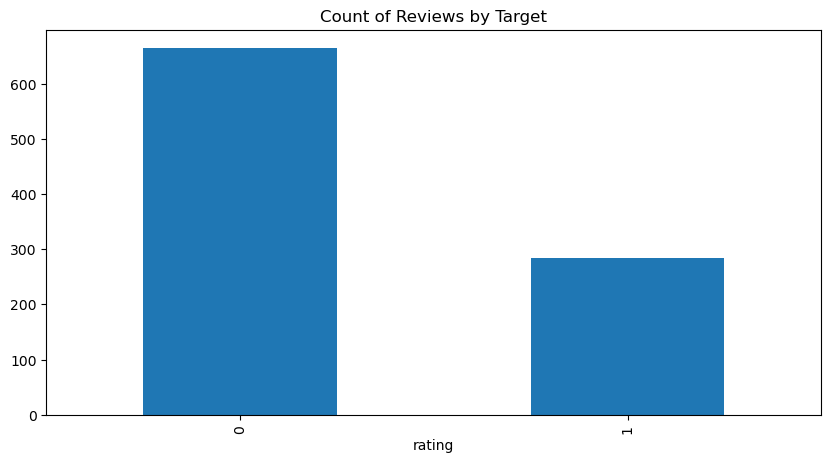

In [110]:
check_class_imbalance(df,df['rating'], 'rating')

# We still have a large imbalance to address. Lets turn our reviews into vector embeddings for further modeling

# Feature Variables

In [117]:
X,y = df.drop("rating", axis=1), df['rating']

# Load Vector Embedding Model

In [120]:

MODEL = 'cardiffnlp/twitter-roberta-base'
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModel.from_pretrained(MODEL)

config.json:   0%|          | 0.00/565 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/501M [00:00<?, ?B/s]

In [121]:
def get_embeddings(text:str):
    """
    - The function get_embeddings is designed to convert input text into a vector representation, 
    or embedding, using a transformer model 
    (like BERT or DistilBERT). These embeddings can be used for various 
    natural language processing tasks such as text classification, clustering, or similarity searches.
    
    - torch.no_grad(): This context manager tells PyTorch not to compute or store gradients. 
    This is important during inference when you only need to do forward propagation, 
    as it reduces memory consumption and speeds up computation.
    
    - last_hidden_state: This tensor contains the output features from the last layer of the 
    transformer for each token. 
    For models like BERT, this typically has dimensions 
    [batch_size, sequence_length, hidden_size]
    
    - This line calculates the mean of the last_hidden_state across the sequence length (tokens). 
    The mean operation reduces the tensor from [batch_size, sequence_length, hidden_size] 
    to [batch_size, hidden_size], resulting in a single vector representation for each 
    sequence in the batch. This vector captures the overall semantic meaning of the text.

    Args:
        text (str): _description_

    Returns:
        _type_: _description_
    """
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    
    with torch.no_grad():
        outputs = model(**inputs)
    
    last_hidden_states = outputs.last_hidden_state
    
    mean_embeddings = last_hidden_states.mean(dim=1)
    return mean_embeddings.numpy()

In [122]:
X['text_embeddings'] = X['review'].apply(lambda x: get_embeddings(x))

features = np.array(X['text_embeddings'].tolist()).reshape(X.shape[0], -1)

# Baseline Model

In [125]:

from sklearn.dummy import DummyClassifier

model = DummyClassifier(strategy='constant', constant=1) 

scores = evaluate_model(features, y, model)
print('Mean: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

Mean: 0.461 (0.002)


# Testing Models without sampling methods

In [126]:
names = ['LR']
models = get_selected_models(names)
testing_selected_models(names, models, features, y)

,Model,Mean,STD
0,LR,0.707937,0.045327


In [127]:
names = ['SVC']
models = get_selected_models(names)
testing_selected_models(names, models, features, y)

,Model,Mean,STD
0,SVC,0.152443,0.076548


In [128]:
names = ['RFC', "XGB"]
models = get_selected_models(names)
testing_selected_models(names, models, features, y)

,Model,Mean,STD
1,XGB,0.631694,0.040463
0,RFC,0.489789,0.061441


In [129]:
names = ['DTC', "GBC"]
models = get_selected_models(names)
testing_selected_models(names, models, features, y)

,Model,Mean,STD
1,GBC,0.617711,0.051726
0,DTC,0.482852,0.053092


# Sampling methods

# SMOTE Methods

In [132]:
X_smote, y_smote = get_over_sampling_methods(features, y, "SMOTE")

In [133]:
names = ['LR']
models = get_selected_models(names)
testing_selected_models(names, models, X_smote, y_smote)

,Model,Mean,STD
0,LR,0.883708,0.016263


In [134]:
names = ['SVC']
models = get_selected_models(names)
testing_selected_models(names, models, X_smote, y_smote)

,Model,Mean,STD
0,SVC,0.838442,0.019916


In [135]:
names = ['RFC', "XGB"]
models = get_selected_models(names)
testing_selected_models(names, models, X_smote, y_smote)

,Model,Mean,STD
1,XGB,0.892013,0.018296
0,RFC,0.891925,0.020901


In [136]:
names = ['DTC', "GBC"]
models = get_selected_models(names)
testing_selected_models(names, models, X_smote, y_smote)

,Model,Mean,STD
1,GBC,0.879388,0.012131
0,DTC,0.776761,0.027982


# BL SMOTE

In [137]:
X_bl_smote, y_bl_smote = get_over_sampling_methods(features, y, "BL-SMOTE")

In [138]:
names = ['LR']
models = get_selected_models(names)
testing_selected_models(names, models, X_bl_smote, y_bl_smote)

,Model,Mean,STD
0,LR,0.877855,0.017406


In [139]:
names = ['SVC']
models = get_selected_models(names)
testing_selected_models(names, models, X_bl_smote, y_bl_smote)

,Model,Mean,STD
0,SVC,0.83317,0.014861


In [140]:
names = ['RFC', "XGB"]
models = get_selected_models(names)
testing_selected_models(names, models, X_bl_smote, y_bl_smote)

,Model,Mean,STD
1,XGB,0.896575,0.014632
0,RFC,0.887515,0.013095


In [141]:
names = ['DTC', "GBC"]
models = get_selected_models(names)
testing_selected_models(names, models, X_bl_smote, y_bl_smote)

,Model,Mean,STD
1,GBC,0.891793,0.009784
0,DTC,0.795310,0.021181


# ADASYN

In [142]:
X_a, y_a = get_over_sampling_methods(features, y, "ADASYN")

In [143]:
names = ['LR']
models = get_selected_models(names)
testing_selected_models(names, models,X_a, y_a)

,Model,Mean,STD
0,LR,0.859835,0.02187


In [144]:
names = ['SVC']
models = get_selected_models(names)
testing_selected_models(names, models,X_a, y_a)

,Model,Mean,STD
0,SVC,0.815222,0.023166


In [145]:
names = ['RFC', "XGB"]
models = get_selected_models(names)
testing_selected_models(names, models,X_a, y_a)

,Model,Mean,STD
1,XGB,0.880595,0.019198
0,RFC,0.878619,0.020805


# SMOTE is giving us our best metrics

              precision    recall  f1-score   support

           0       0.95      0.79      0.86       112
           1       0.78      0.94      0.86        88

    accuracy                           0.86       200
   macro avg       0.86      0.87      0.86       200
weighted avg       0.87      0.86      0.86       200



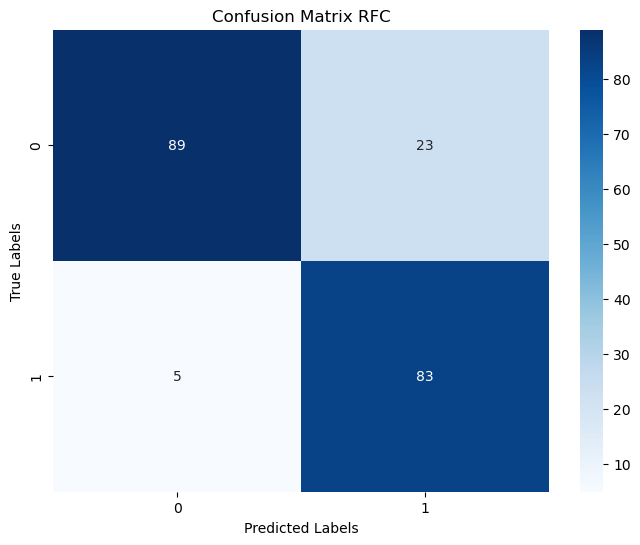

              precision    recall  f1-score   support

           0       0.96      0.73      0.83       112
           1       0.74      0.97      0.84        88

    accuracy                           0.83       200
   macro avg       0.85      0.85      0.83       200
weighted avg       0.87      0.83      0.83       200



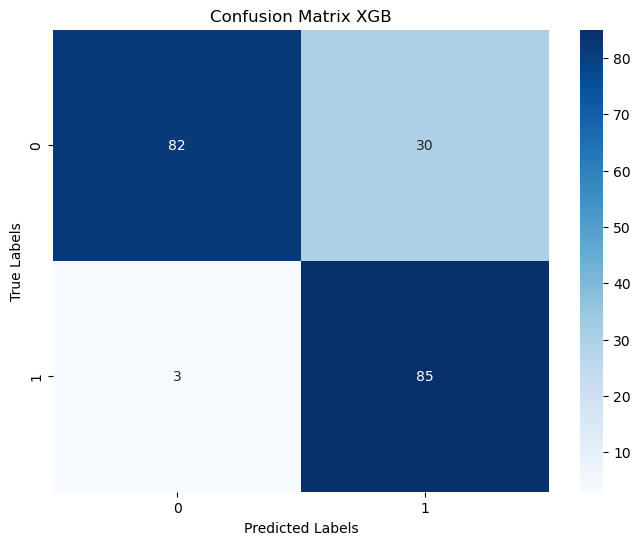

,Model,Validation Accuracy,Test Accuracy
0,RFC,0.869347,0.860
1,XGB,0.849246,0.835


In [151]:
names = ['RFC', "XGB"]
models = get_selected_models(names)
test_train_test_val_splits_on_models(names, models, X_bl_smote, y_bl_smote)

              precision    recall  f1-score   support

           0       0.99      0.76      0.86       112
           1       0.76      0.99      0.86        88

    accuracy                           0.86       200
   macro avg       0.88      0.87      0.86       200
weighted avg       0.89      0.86      0.86       200



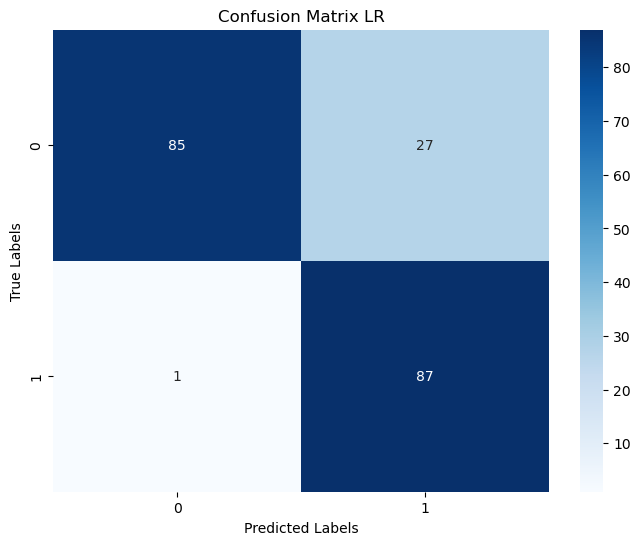

,Model,Validation Accuracy,Test Accuracy
0,LR,0.859296,0.86


In [152]:
names = ["LR"]
models = get_selected_models(names)
test_train_test_val_splits_on_models(names, models, X_bl_smote, y_bl_smote)

              precision    recall  f1-score   support

           0       0.99      0.79      0.88       112
           1       0.78      0.99      0.87        88

    accuracy                           0.88       200
   macro avg       0.89      0.89      0.87       200
weighted avg       0.90      0.88      0.88       200



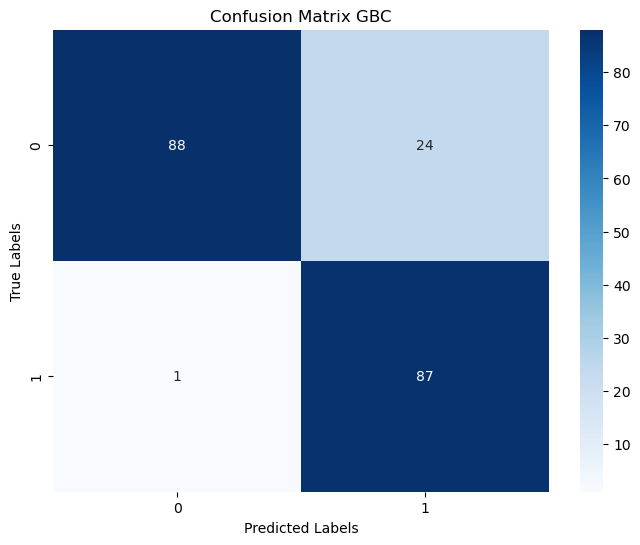

,Model,Validation Accuracy,Test Accuracy
0,GBC,0.854271,0.875


In [153]:
names = ["GBC"]
models = get_selected_models(names)
test_train_test_val_splits_on_models(names, models, X_bl_smote, y_bl_smote)

# Hyperparameter Tuning

/Users/maukanmir/miniforge3/envs/machine-learning-env/lib/python3.9/site-packages/sklearn/utils/optimize.py:43: LineSearchWarning: The line search algorithm did not converge
  ret = line_search_wolfe2(
/Users/maukanmir/miniforge3/envs/machine-learning-env/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/Users/maukanmir/miniforge3/envs/machine-learning-env/lib/python3.9/site-packages/sklearn/utils/optimize.py:43: LineSearchWarning: The line search algorithm did not converge
  ret = line_search_wolfe2(
/Users/maukanmir/miniforge3/envs/machine-learning-env/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/Users/maukanmir/miniforge3/envs/machine-learning-env/lib/python3.9/site-packages/sklearn/utils/optimize.py:43: LineSearchWarning: The line search algorithm did not converge
  ret = line_search_wolfe2(
/Users/maukanmir/miniforge3/

Best parameters: {'C': 100, 'solver': 'newton-cg'}
Best cross-validation score: 0.874
Test accuracy: 0.877
              precision    recall  f1-score   support

           0       0.92      0.80      0.86       184
           1       0.85      0.94      0.89       215

    accuracy                           0.88       399
   macro avg       0.88      0.87      0.87       399
weighted avg       0.88      0.88      0.88       399



/Users/maukanmir/miniforge3/envs/machine-learning-env/lib/python3.9/site-packages/sklearn/utils/optimize.py:43: LineSearchWarning: The line search algorithm did not converge
  ret = line_search_wolfe2(
/Users/maukanmir/miniforge3/envs/machine-learning-env/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


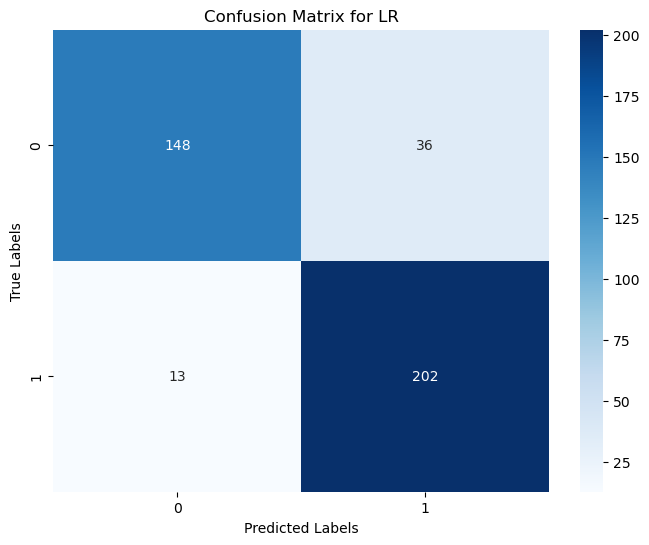

In [160]:
logistic_regression_tune_cv(X_smote,y_smote)

# Tree Models

Best score for RFC: 0.885
Best parameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 300}
Validation Test accuracy for RFC: 0.874
Test accuracy for RFC: 0.855
---------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.95      0.79      0.86       112
           1       0.78      0.94      0.85        88

    accuracy                           0.85       200
   macro avg       0.86      0.86      0.85       200
weighted avg       0.87      0.85      0.86       200



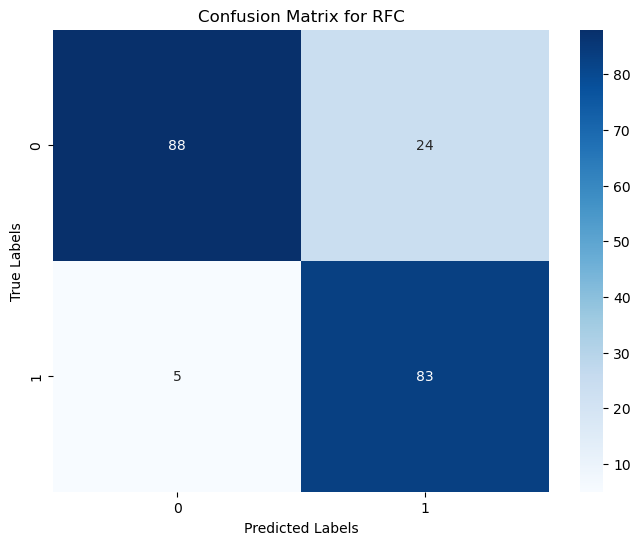

Best score for GBC: 0.892
Best parameters: {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 100}
Validation Test accuracy for GBC: 0.879
Test accuracy for GBC: 0.855
---------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.94      0.79      0.86       112
           1       0.78      0.93      0.85        88

    accuracy                           0.85       200
   macro avg       0.86      0.86      0.85       200
weighted avg       0.87      0.85      0.86       200



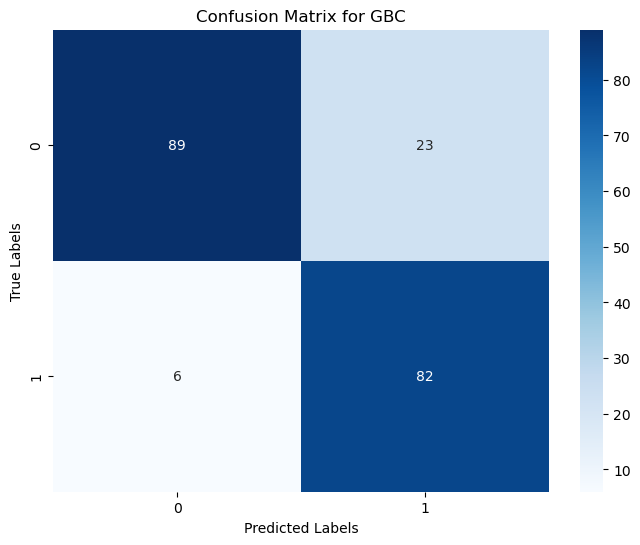

Best score for XGB: 0.889
Best parameters: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 100}
Validation Test accuracy for XGB: 0.869
Test accuracy for XGB: 0.845
---------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.94      0.78      0.85       112
           1       0.77      0.93      0.84        88

    accuracy                           0.84       200
   macro avg       0.85      0.85      0.84       200
weighted avg       0.86      0.84      0.85       200



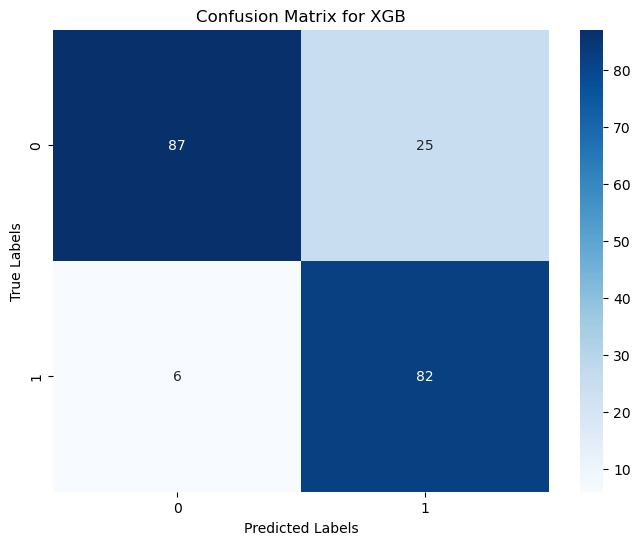

,Model,Best CV Score,Validation Accuracy,Test Accuracy,Best Parameters
0,RFC,0.885326,0.874372,0.855,"{'max_depth': 10, 'min_samples_leaf': 2, 'min_..."
1,GBC,0.892322,0.879397,0.855,"{'learning_rate': 0.2, 'max_depth': 7, 'n_esti..."
2,XGB,0.888543,0.869347,0.845,"{'learning_rate': 0.2, 'max_depth': 5, 'n_esti..."


In [167]:
names = ["RFC", "GBC", "XGB"]
models = get_selected_models(names)

param_grid = {
    'RFC': {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
    },
    'GBC': {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7]
    },
    'XGB': {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.2]
    }
}

metric = make_scorer(f1_score)
val_grid_search_selected_models(param_grid, names, models, X_smote, y_smote, metric)